In [ ]:
!pip install torch_geometric
!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=0b052867394c7fd386a9182fa400f7fc43f68a53d1bc8b91c85f8efec81ed3d8
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import DataLoader
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import numpy as np
import networkx as nx
from torch_geometric.utils.negative_sampling import negative_sampling
import matplotlib.pyplot as plt

In [ ]:
dataset = PygLinkPropPredDataset(name="ogbl-ddi",root='./dataset')
dataset

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:02<00:00, 16.27it/s]


Extracting ./dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 456.50it/s]

Saving...



Done!


PygLinkPropPredDataset()

In [ ]:
dataset.get_summary()

PygLinkPropPredDataset (#graphs=1):
+------------+----------+---------------+
|            |   #nodes |        #edges |
|------------+----------+---------------|
| mean       |     4267 |   2.13582e+06 |
| std        |      nan | nan           |
| min        |     4267 |   2.13582e+06 |
| quantile25 |     4267 |   2.13582e+06 |
| median     |     4267 |   2.13582e+06 |
| quantile75 |     4267 |   2.13582e+06 |
| max        |     4267 |   2.13582e+06 |
+------------+----------+---------------+

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim = 256
num_layers = 2
dropout = 0.2
node_emb_dim = 256
batch_size = 64*1024
lr=0.005
num_epochs = 300

In [ ]:
# g = pyg.utils.to_networkx(dataset[0], to_undirected=True)
# nx.draw(g)

In [ ]:
class GNNStack(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,num_layers,dropout,emb=False):
    super().__init__()
    conv_model = pyg.nn.SAGEConv
    self.convs = nn.ModuleList()
    self.convs.append(conv_model(input_dim,hidden_dim))
    self.num_layers = num_layers
    self.dropout = dropout
    self.emb = emb

    assert (self.num_layers >= 1)
    for l in range(self.num_layers - 1):
        self.convs.append(conv_model(hidden_dim, hidden_dim))

    self.post_mp = nn.Sequential(
        nn.Linear(hidden_dim,hidden_dim),
        nn.Dropout(self.dropout),
        nn.Linear(hidden_dim,output_dim))

  def forward(self,x,edge_index):
    for i in range(self.num_layers):
      x = self.convs[i](x,edge_index)
      x = F.relu(x)
      x = F.dropout(x,p = self.dropout,training=self.training)
    x = self.post_mp(x)
    if self.emb:
      return x
    return F.softmax(x,dim=1)

In [ ]:
class LinkPredictor(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,num_layers,dropout):
    super().__init__()
    self.lins = nn.ModuleList()
    self.lins.append(nn.Linear(input_dim,hidden_dim))
    for _ in range(num_layers-2):
      self.lins.append(nn.Linear(hidden_dim,hidden_dim))
    self.lins.append(nn.Linear(hidden_dim,output_dim))
    self.dropout = dropout

  def forward(self,x_i,x_j):
    x = x_i * x_j
    for lin in self.lins[:-1]:
      x = lin(x)
      x = F.relu(x)
      x = F.dropout(x,p=self.dropout,training = self.training)
    x = self.lins[-1](x)
    return torch.sigmoid(x)


In [ ]:
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
  """
  params:
        model :           Used for updating graph node embedddings
        link_predictor :  Predicting whether an edge exists between or not

  """
  model.train()
  link_predictor.train()
  train_losses = []
  for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
    optimizer.zero_grad()

    # Run message passing on the initial node embeddings to get updated node embeddings
    node_emb = model(emb , edge_index) #(N , D)

    # Predict class probabilities on the batch of positive edges using link_predictor
    pos_edge = pos_train_edge[edge_id].T #(2 , Batch)
    pos_pred = link_predictor(node_emb[pos_edge[0]].to(torch.float),node_emb[pos_edge[1]].to(torch.float))

    neg_edge = negative_sampling(edge_index , num_nodes = emb.shape[0],num_neg_samples=edge_id.shape[0], method = "sparse")
    neg_pred = link_predictor(node_emb[neg_edge[0]],node_emb[neg_edge[1]])

    loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1-neg_pred + 1e-15).mean()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  return sum(train_losses)/len(train_losses)

Hits@k is a metric used to evaluate the accuracy of a recommendation system or information retrieval system. It measures how many of the top k items recommended to a user are relevant to that user. The evaluation involves comparing the recommended items to a set of ground truth items that are known to be relevant to the user.

Here's how Hits@k is typically evaluated:

User Data Preparation: You need data about users and their interactions (such as clicks, purchases, or ratings) with items. From this data, you can create a test set for each user. The test set contains a set of items that the user has interacted with (the positive items) and a set of items that the user has not interacted with (the negative items).

Recommendation Generation: Using your recommendation algorithm, generate a list of top k items for each user in your test set.

Evaluation: For each user:

Identify the k recommended items.
Check if any of the recommended items are in the set of positive items (items the user has interacted with). If there is at least one positive item in the top k recommendations, Hits@k is 1 for that user; otherwise, it is 0.
Aggregate the Results: Calculate Hits@k for all users and then average these values to get an overall Hits@k score for your recommendation system.``

The Hits@k metric provides insights into the ability of your recommendation system to suggest relevant items within the top k positions. It is a simple and intuitive way to evaluate the performance of recommendation algorithms, especially in scenarios where only a limited number of recommendations can be shown to users.

In [ ]:
def test(model, link_predictor, emb, edge_index, split_edge, batch_size, optimizer,evaluator):
  model.eval()
  link_predictor.eval()

  node_emb = model(emb,edge_index)

  pos_val_edge = split_edge['valid']['edge']
  neg_val_edge = split_edge['valid']['edge_neg']

  pos_test_edge = split_edge['test']['edge']
  neg_test_edge = split_edge['test']['edge_neg']


  pos_val_preds = []
  for edge_id in DataLoader(range(pos_val_edge.shape[0]),batch_size):
    pos_edge = pos_val_edge[edge_id].t()
    pos_val_preds += [link_predictor(node_emb[pos_edge[0]],node_emb[pos_edge[1]]).squeeze().cpu()]
  pos_val_pred = torch.cat(pos_val_preds,dim=0)

  neg_val_preds = []
  for edge_id in DataLoader(range(neg_val_edge.shape[0]),batch_size):
    neg_edge = neg_val_edge[edge_id].t()
    neg_val_preds += [link_predictor(node_emb[neg_edge[0]],node_emb[neg_edge[1]]).squeeze().cpu()]
  neg_val_pred = torch.cat(neg_val_preds,dim=0)

  pos_test_preds = []
  for edge_id in DataLoader(range(pos_test_edge.shape[0]),batch_size):
    pos_edge = pos_test_edge[edge_id].t()
    pos_test_preds += [link_predictor(node_emb[pos_edge[0]],node_emb[pos_edge[1]]).squeeze().cpu()]
  pos_test_pred = torch.cat(pos_test_preds,dim=0)

  neg_test_preds = []
  for edge_id in DataLoader(range(neg_test_edge.shape[0]),batch_size):
    neg_edge = neg_test_edge[edge_id].t()
    neg_test_preds += [link_predictor(node_emb[neg_edge[0]],node_emb[neg_edge[1]]).squeeze().cpu()]
  neg_test_pred = torch.cat(neg_test_preds,dim=0)

  results = {}
  for K in [20, 50, 100]:
      evaluator.K = K
      valid_hits = evaluator.eval({
          'y_pred_pos': pos_val_pred,
          'y_pred_neg': neg_val_pred,
      })[f'hits@{K}']
      test_hits = evaluator.eval({
          'y_pred_pos': pos_test_pred,
          'y_pred_neg': neg_test_pred,
      })[f'hits@{K}']

      results[f'Hits@{K}'] = (valid_hits, test_hits)
  return results

In [ ]:
split_edge = dataset.get_edge_split()
pos_train_edge = split_edge['train']['edge'].to(device)

graph = dataset[0]
edge_index = graph.edge_index.to(device)

evaluator = Evaluator(name="ogbl-ddi")

emb = torch.nn.Embedding(graph.num_nodes,node_emb_dim).to(device)

model = GNNStack(node_emb_dim,hidden_dim,hidden_dim,num_layers,dropout,True).to(device)
link_predictor = LinkPredictor(hidden_dim,hidden_dim,1,num_layers+1,dropout).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) +  list(emb.parameters()),
    lr = lr,
    weight_decay = 0
)

In [ ]:
train_losses = []
val_hits = []
test_hits = []
for epoch in range(num_epochs):
  loss = train(model,link_predictor,emb.weight,edge_index,pos_train_edge,batch_size,optimizer)
  print(f'Epoch: {epoch + 1}: Loss: {loss}')
  train_losses.append(loss)

  if(epoch % 10 == 0):
    result = test(model,link_predictor,emb.weight,edge_index,split_edge,batch_size,optimizer,evaluator)
    val_hits.append(result['Hits@20'][0])
    test_hits.append(result['Hits@20'][1])
    print(result)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1: Loss: 1.4084933365092558
{'Hits@20': (6.742128564900479e-05, 2.2473761883001596e-05), 'Hits@50': (0.0001423338252590101, 6.742128564900479e-05), 'Hits@100': (0.00041201896785502925, 0.00027717639655701966)}
Epoch: 2: Loss: 1.0946708777371574
Epoch: 3: Loss: 0.8993871106820948
Epoch: 4: Loss: 0.7941716944470125
Epoch: 5: Loss: 0.7274510334519779
Epoch: 6: Loss: 0.7030039745218614
Epoch: 7: Loss: 0.6648043674581191
Epoch: 8: Loss: 0.6389236169702867
Epoch: 9: Loss: 0.6131329746807322
Epoch: 10: Loss: 0.5938777257414425
Epoch: 11: Loss: 0.5815202839234296
{'Hits@20': (0.23040100682453235, 0.1466787525563904), 'Hits@50': (0.3170148851216205, 0.21792057772550547), 'Hits@100': (0.37854055390331787, 0.3605390706350336)}
Epoch: 12: Loss: 0.5674941504702848
Epoch: 13: Loss: 0.5581614199806663
Epoch: 14: Loss: 0.5490710104213041
Epoch: 15: Loss: 0.5387231462142047
Epoch: 16: Loss: 0.5322974920272827
Epoch: 17: Loss: 0.5248286408536574
Epoch: 18: Loss: 0.5203942235778359
Epoch: 19: Loss

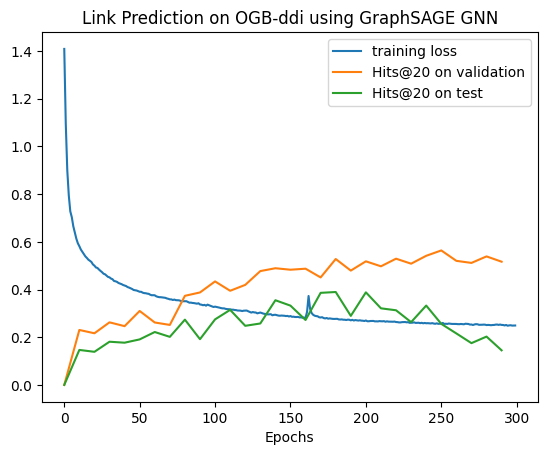

In [ ]:
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_losses,label="training loss")
plt.plot(np.arange(0,num_epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(0,num_epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
import pickle

In [ ]:
torch.save(model,'model.pt')

In [ ]:
torch.save(link_predictor,'link_predictor.pt')